# Sumário

- Configurações Iniciais
- Leitura
  - Média de Vendas
- Análise Exploratória
  - Sazonalidade com 7 dias
- Modelagem do Problema
  - Função `auto_arima`
  - Testes dos Parâmetros
  - Diagnóstico para `auto_arima`
  - Diagnóstico para Modelo Corrente
  - Predições para as observações de Validação
  - Comparações entre os Modelos Escolhidos

# Configurações Iniciais

In [1]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
import zipfile as zf # handle zip files

# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots

# settings
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [15,7]
plt.rcParams['font.size'] = 15

In [2]:
# TIME SERIES
from pmdarima.arima import auto_arima, ARIMA
from pmdarima.utils.visualization import plot_pacf, plot_acf
from pmdarima.arima import ADFTest
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Leitura

In [3]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh', title=''):
    """ Gráficos ACF, PACF, QQPLOT e de Probabilidades. """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return


# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

In [4]:
# Loading files
unzip_fs = zf.ZipFile('competitive-data-science-predict-future-sales.zip', 'r')

aux = unzip_fs.open('sales_train.csv', 'r')
sales = pd.read_csv(aux)
aux.close()

# aux = unzip_fs.open('items.csv', 'r')
# item = pd.read_csv(aux)
# aux.close()


# Dont need to load
# aux = unzip_fs.open("item_categories.csv")
# item_cat=pd.read_csv(aux)
# aux.close()

# sub=pd.read_csv("sample_submission.csv")

# aux = unzip_fs.open("shops.csv")
# shops=pd.read_csv(aux)
# aux.close()

# aux = unzip_fs.open("test.csv")
# test=pd.read_csv(aux)
# aux.close()
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


Temos um conjunto de dados formados pelas seguintes colunas:
- `date` : data da movimentação de um produto em determinada filial;
- `date_block_num` : um índice do mês que em ocorreram as movimentações;
- `shop_id` : id da filial;
- `item_id` : id do item vendido;
- `item_price` : preço do item vendido (diferente para cada filial);
- `item_cnt_day` : quantidade de itens movimentados.

In [5]:
# formatando a coluna 'data' das vendas:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 134.4 MB
None


### Média

Nosso objetivo é modelar a média de itens vendidos por todas as filiais por dia, ou seja, a média de vendas de toda a companhia por dia, de modo que possamos predizer a venda média nos próximos 60 dias.

Para isso, agrupamos as somas das observações por data e id da loja e depois tiramos a média dos itens vendidos por dia.

Em seguida, separamos as últimas 60 observações para avaliarmos a predição do modelo final.

Obs de treino: 974 
Obs de teste: 60


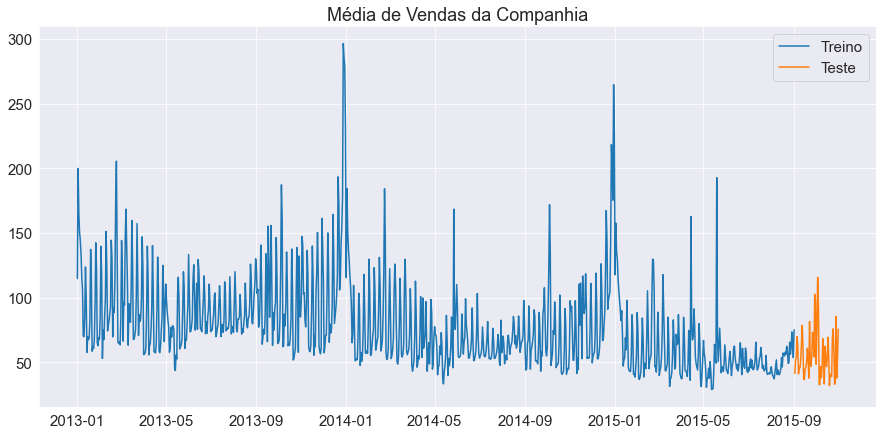

In [6]:
# agrupando todas as vendas da companhia
sales_shop = sales.groupby(by=['date',"shop_id"])[["item_cnt_day"]].sum().reset_index()
sales_mean = sales_shop.groupby(by=['date'])[["item_cnt_day"]].mean()

# separando em conjunto de treino e validação
teste = sales_mean.iloc[974:]
treino = sales_mean.iloc[:-60]
print(f'Obs de treino: {treino.shape[0]} \nObs de teste: {teste.shape[0]}')

plt.plot(treino, label='Treino')
plt.plot(teste, label="Teste")
plt.title('Média de Vendas da Companhia')
plt.legend()
plt.show()

# Análise Exploratória

Com base na existência de tendência e sazonalidade, podemos adotar dois tipos de modelos:

Aditivo:
$$
Z_{t} = S_{t} + T_{t} + Y_{t}
$$

Multiplicativo:
$$
Z_{t} = S_{t} T_{t} Y_{t}
$$

In [7]:
def decompose(series, period, model = 'multiplicative'):
    """Function to decompose the series in tree components:
    1- trend; 2- seasonality; 3- noise
    return: (decompose_object, noise_component)
    """
    resm = sm.tsa.seasonal_decompose(series.values,period=period,model=model)
    #plt.figure(figsize=(16,12))
    #print('Modelo Aditivo')
    fig = resm.plot()
    fig.show()

    # salva resíduos
    residuos = pd.DataFrame(resm.resid)
    residuos = residuos.dropna()[0].to_numpy()

    return resm, residuos

# para remover tendencia
def difference(dataset, interval=1):
    """ Function for differentiation: z(t) - z(t-inteval)
    return: differentiated series (length minus `interval`)
    """
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


## Modelos com período de 7 dias

Primeiro, veremos a decomposição supondo uma relação aditiva entre as componentes.

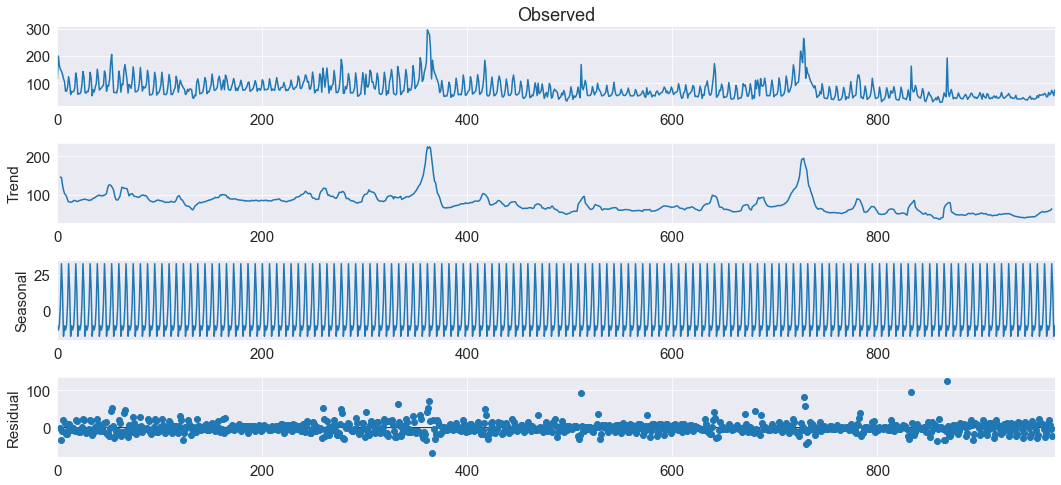

In [8]:
res_a = decompose(treino, period = 7, model = 'additive')

Para retirar essa estranha tedência, considere a diferenciação da série em um nível, e novamente a decomposição.

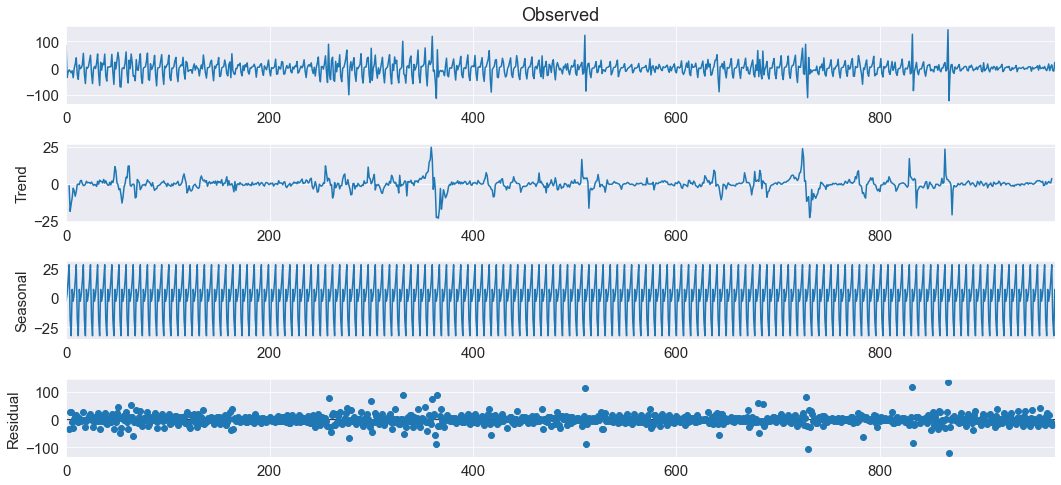

In [9]:
aux = decompose(difference(treino.to_numpy(), 1), period = 7, model = 'additive')

Temos uma considerável melhora nos resultados considerando a diferenciação.

Mas continuando, vamos supor uma relação multiplicativa entre as componentes agora.

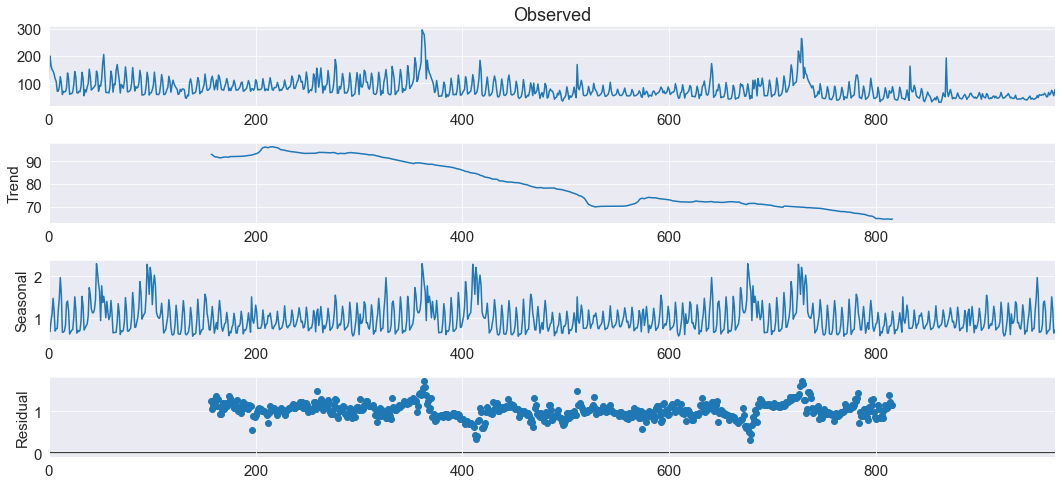

In [40]:
res_m = decompose(treino, period = 315)

Novamente, considere a diferenciação de um nível (também adicionamos uma constante, de 150, para que a função funcionasse, e não há nenhum problema, isso apenas deslocará a média para 150):

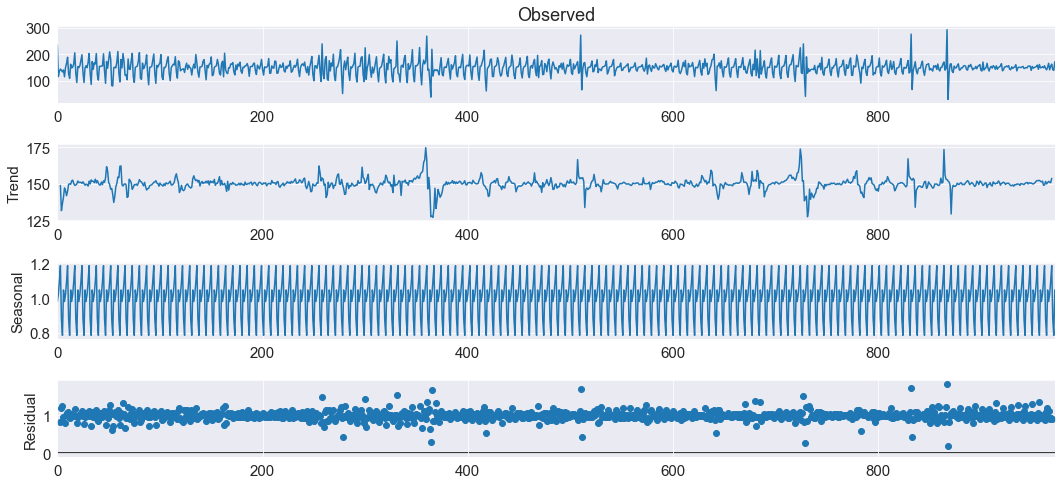

In [12]:
aux = decompose(difference(treino.to_numpy(), 1)+150, period = 7)

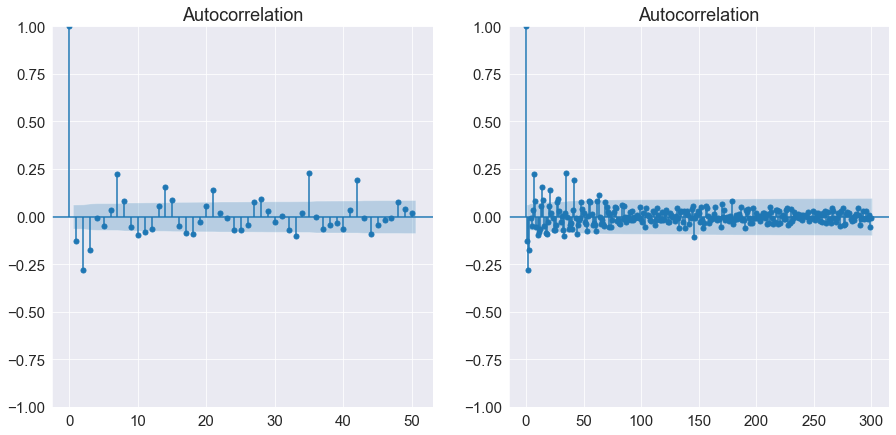

In [15]:
fig = plt.figure()
ax_1 = plt.subplot2grid((1,2), (0, 0))
ax_2 = plt.subplot2grid((1,2), (0, 1))
#plot_acf(aux[1], lags = 50, alpha=0.05, ax=ax_1)
#plot_acf(aux[1], lags = 300, alpha = 0.05, ax=ax_2)
smt.graphics.plot_acf(aux[1], lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_acf(aux[1], lags=300, ax=ax_2, alpha=0.05)
plt.show()

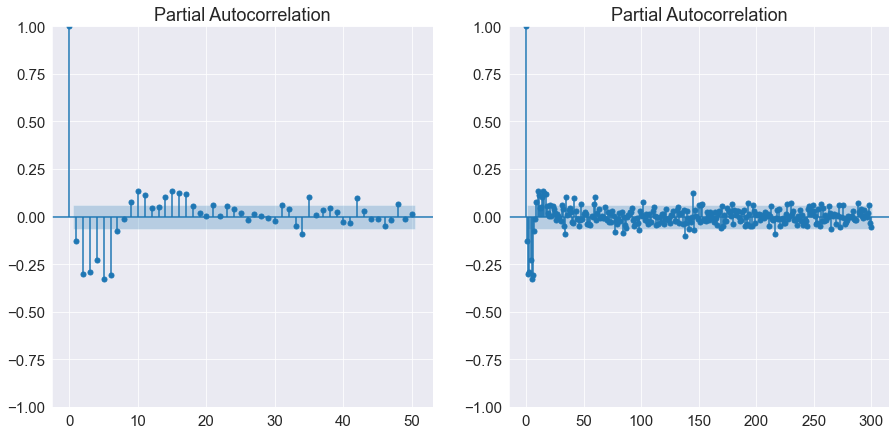

In [16]:
fig = plt.figure()
ax_1 = plt.subplot2grid((1,2), (0, 0))
ax_2 = plt.subplot2grid((1,2), (0, 1))
#plot_pacf(aux[1], lags = 50, alpha=0.05, ax=ax_1)
#plot_pacf(aux[1], lags = 300, alpha = 0.05, ax=ax_2)
smt.graphics.plot_pacf(aux[1], lags=50, ax=ax_1, alpha=0.05)
smt.graphics.plot_pacf(aux[1], lags=300, ax=ax_2, alpha=0.05)
plt.show()

E a partir do que vemos nos gráficos, vamos definir uma quantidade inicial de parâmetros para os dados.

# Modelagem do Problema

## Função `auto_arima`

Considerando a sazonalidade de 7 dias e os resultados da análise exploratória, utilizamos o autoarima para realizar a busca pelos melhores hiperparâmetros.

In [ ]:
arima_model =  auto_arima(treino,start_p=0, d=None, start_q=0,
                          max_p=5, max_d=5, max_q=5, start_P=5,
                          D=None, start_Q=5, max_P=5, max_D=5,
                          max_Q=5, m=315, seasonal=True,
                          error_action='warn', trace = True,
                          supress_warnings=True, stepwise = True,
                          random_state=20, n_fits = 50 )


Performing stepwise search to minimize aic


Então, a seguir, o melhor modelo que a função escolheu.

In [170]:
print(arima_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  974
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -4175.325
Date:                                   Sat, 10 Dec 2022   AIC                           8372.649
Time:                                           14:46:12   BIC                           8426.334
Sample:                                       01-01-2013   HQIC                          8393.080
                                            - 09-01-2015                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.144      0.885    

## Testes do Parâmetros

Observando os p-valores, referentes ao teste de nulidade dos coeficientes, notamos que alguns coeficiente são estatisticamente iguais a zero. Assim, ajustaremos modelos mais simples levando em conta esses resultados.

In [51]:
# SARIMA (4,1,1) x (1,0,2)_7
print(ARIMA((4,1,1), seasonal_order=(1, 0, 2, 7) ).fit(treino).summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  974
Model:             SARIMAX(4, 1, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -4176.469
Date:                                Sat, 10 Dec 2022   AIC                           8372.938
Time:                                        20:52:05   BIC                           8421.742
Sample:                                    01-01-2013   HQIC                          8391.511
                                         - 09-01-2015                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0002      0.001     -0.146      0.884      -0.003       0.003
ar.

In [52]:
# SARIMA (3,1,1) x (1,0,3)_7
print(ARIMA((3,1,1), seasonal_order=(1, 0, 3, 7) ).fit(treino).summary())

                                         SARIMAX Results                                         
Dep. Variable:                                         y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, [1, 2, 3], 7)   Log Likelihood               -4176.306
Date:                                   Sat, 10 Dec 2022   AIC                           8372.611
Time:                                           20:52:42   BIC                           8421.415
Sample:                                       01-01-2013   HQIC                          8391.185
                                            - 09-01-2015                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9.148e-05      0.001     -0.114      0.909    

In [53]:
# SARIMA (3,1,1) x (1,0,1)_7
print(ARIMA((3,1,1), seasonal_order=(1, 0, 1, 7) ).fit(treino).summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4181.142
Date:                           Sat, 10 Dec 2022   AIC                           8378.284
Time:                                   20:53:19   BIC                           8417.328
Sample:                               01-01-2013   HQIC                          8393.143
                                    - 09-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.332      0.740      -0.002       0.003
ar.L1          0.7017      0.024     29.758

Portanto, segundo os teste, definiremos o modelo corrente como SARIMA: $(3,1,1) \times (1,0,1)_7$.

In [54]:
working_model = ARIMA((3,1,1), seasonal_order=(1, 0, 1, 7) ).fit(treino)
print(working_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  974
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -4181.142
Date:                           Sat, 10 Dec 2022   AIC                           8378.284
Time:                                   20:56:03   BIC                           8417.328
Sample:                               01-01-2013   HQIC                          8393.143
                                    - 09-01-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.001      0.332      0.740      -0.002       0.003
ar.L1          0.7017      0.024     29.758

## Diagnóstico para `auto_arima`

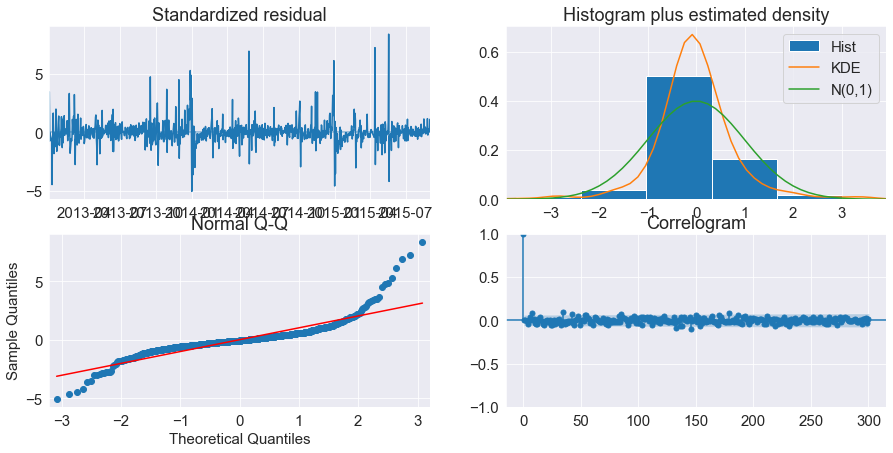

In [175]:
acf = arima_model.plot_diagnostics(lags = 300)

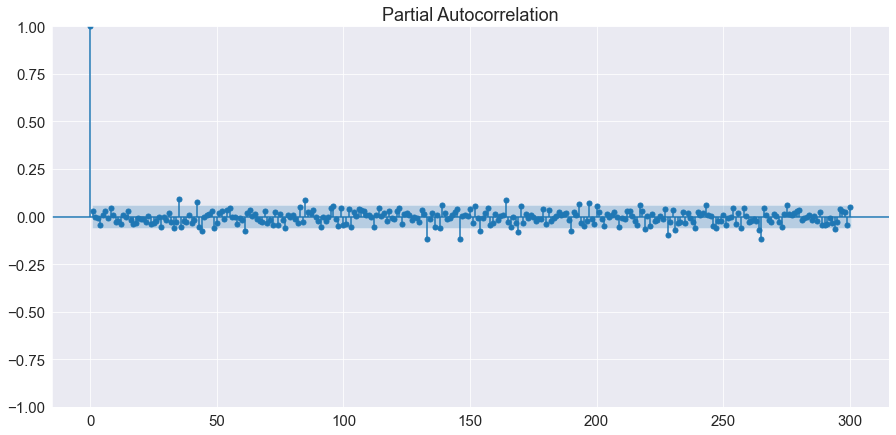

In [176]:
plot_pacf(arima_model.resid(), lags = 300, alpha = 0.05 )

## Diagnóstico para Modelo Corrente


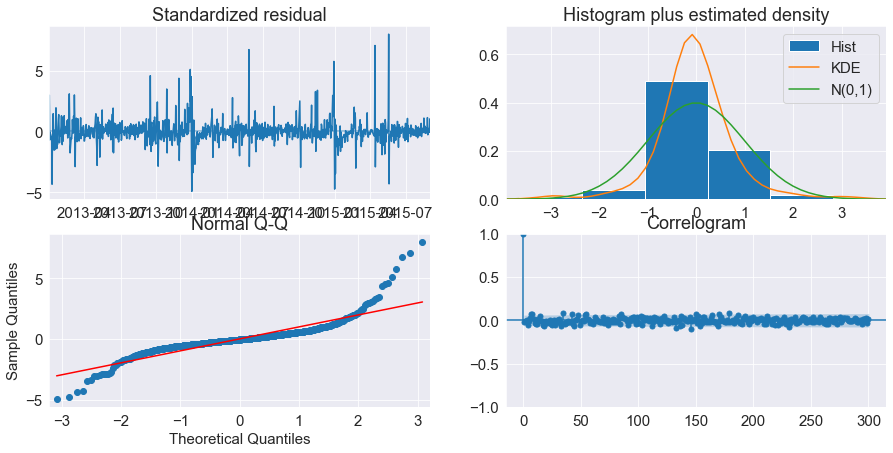

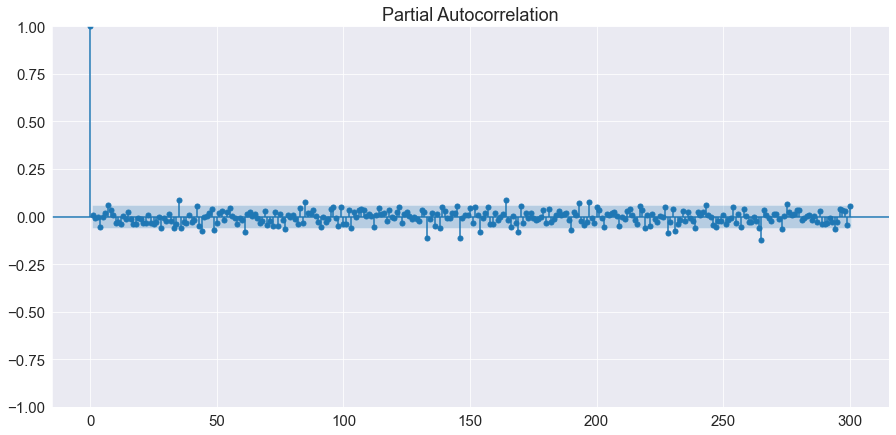

In [180]:
acf = working_model.plot_diagnostics(lags = 300)
plot_pacf(working_model.resid(), lags = 300, alpha = 0.05)

## Predições para as observações de Validação

Por fim, realizamos a predição das observações retiradas do conjunto original para ambos os modelos ajustados.

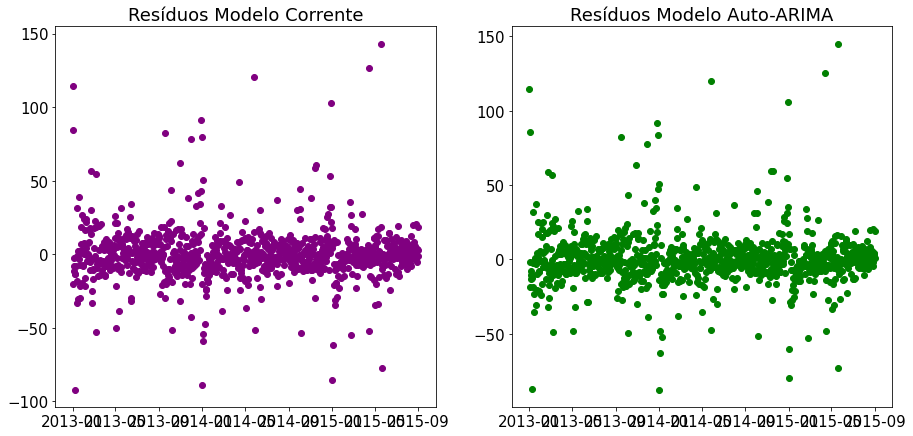

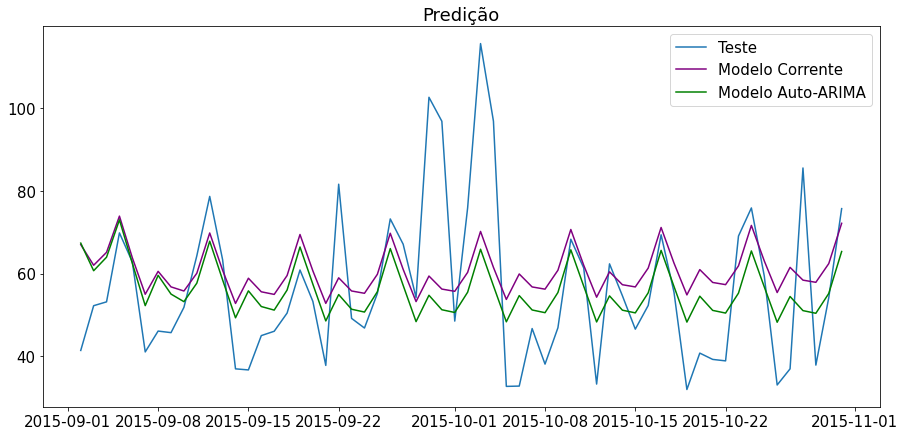

In [65]:
residuos = working_model.resid()
predicao = pd.DataFrame(working_model.predict(n_periods = 60)).set_index(teste.index)

res_oldmodel = arima_model.resid()
pred_oldmodel = pd.DataFrame(arima_model.predict(n_periods = 60)).set_index(teste.index)

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x=residuos.index, y=residuos, color='purple')
plt.title("Resíduos Modelo Corrente")
plt.subplot(1,2,2)
plt.scatter(x=res_oldmodel.index, y=res_oldmodel, color='green')
plt.title("Resíduos Modelo Auto-ARIMA")
plt.plot()

plt.figure()
# plt.plot(treino,label="Training")
plt.plot(teste, label="Teste")
plt.plot(predicao, label="Modelo Corrente", color='purple')
plt.plot(pred_oldmodel, label='Modelo Auto-ARIMA', color='green')
plt.title("Predição")
plt.legend()
plt.show()

## Comparações entre os Modelos Escolhidos

In [66]:
# testes nos residuos:

## Normalidade - Shapiro-Wilk
pv_shapiro_arima = scs.shapiro(res_oldmodel).pvalue
pv_shapiro_corrente = scs.shapiro(residuos).pvalue

## Homocedasticidade - Goldfeld-Quandt
# het_goldfeldquandt null hypothesis that the variaces are not constant
pv_var_corrente = het_goldfeldquandt(residuos,  treino.values, alternative= 'two-sided')[1]
pv_var_arima = het_goldfeldquandt(res_oldmodel, treino.values, alternative= 'two-sided')[1]

## Raiz Unitaria - ADFuller
pv_corrente = adfuller(residuos)[1]
pv_arima = adfuller(res_oldmodel)[1]

In [58]:
def mse(y, y_hat):
    """Function to calculate the Mean Squared Error."""
    y = y.to_numpy()
    y_hat = y_hat.to_numpy()

    mse = sum((y-y_hat)**2)/len(y)

    return mse

In [195]:
eqm_corrente= mse(teste, predicao)
eqm_oldmodel = mse(teste, pred_oldmodel)

pd.DataFrame(np.array([[eqm_corrente[0],pv_shapiro_corrente,pv_var_corrente,pv_corrente],
                      [eqm_oldmodel[0],pv_shapiro_arima, pv_var_arima,pv_arima]]),
             columns= ['MSE', 'ADFuller', 'Shapiro', 'Goldfeld'],
             index = ['Modelo Corrente', 'Modelo Auto-ARIMA'])

,MSE,ADFuller,Shapiro,Goldfeld
Modelo Corrente,293.218718,2.345912e-33,0.136054,1.240684e-17
Modelo Auto-ARIMA,273.316029,1.466654e-33,0.123093,0.000000e+00


Assim, ambos os modelos satisfazem as suposições de estacionariedade e normalidade dos resíduos, pelo teste de raiz unitária de ADFuller e o de normalidade de Shapiro-Wilk. Contudo, nenhum dos dois  possui homogeneidade de variância pelo teste de Goldfeld. Por fim, o modelo com menor erro quadrático na previsão é o gerado pelo Auto-ARIMA.